### Import knihoven a konfigurace

In [1]:
from improutils import *

import os
import io

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.cloud import vision
!sudo apt-get install tesseract-ocr-ces -y
!pip install pytesseract
import pytesseract

%matplotlib inline
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

/root/venv/lib/python3.11/site-packages/qrdet/qrdet.py:125: UserWarning: QRDetector has been updated to use the new YoloV8 model. Use legacy=True when calling detect for backwards compatibility with 1.x versions. Or update to new output (new output is a tuple of dicts, containing several new information (1.x output is accessible through 'bbox_xyxy' and 'confidence').Forget this message if you are reading it from QReader. [This is a first download warning and will be removed at 2.1]
  warn("QRDetector has been updated to use the new YoloV8 model. Use legacy=True when calling detect "



The following additional packages will be installed:
  libgif7 liblept5 libtesseract4 tesseract-ocr tesseract-ocr-eng
  tesseract-ocr-osd
The following NEW packages will be installed:
  libgif7 liblept5 libtesseract4 tesseract-ocr tesseract-ocr-ces
  tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 7 newly installed, 0 to remove and 5 not upgraded.
Need to get 8,477 kB of archives.
After this operation, 2

## Úkol

Výchozím bodem k tomuto úkolu je [cvičení na perspektivní transformaci](https://courses.fit.cvut.cz/BI-SVZ/tutorials/files/6/perspective-measuring-length.html).

### První část - rovnání dokumentu a následná aplikace OCR
Práce probíhá se souborem `ocr_img.jpg` na kterém se nachází dokument známých rozměrů (papír A4). Dokument je potřeba transformovat na kolmý pohled a následně využít Google Cloud Vision API k automatizovanému přečtení textu pomocí OCR. Za tuto část je možné získat maximálně **3 body** a **až 1 prémiový**.

![](ocr_img.jpg)

**1) Načtěte obrázek, zobrazte ho a uložte si pole cílových korespondečních souřadnic rohů dokumentu.**

In [14]:
image = load_image('ocr_img.jpg')
# tried some options. 8x seems to be the best one
real_world_pts = np.array([(0, 0), (0, 8*210), (8*297, 8*210), (8*297, 0)])

**2) Pomocí oblíbeného grafického editoru vyberte obrazové souřadnice rohů dokumentu ve snímku.**  
Souřadnice musí korespondovat pořadím, takže pokud je levý roh první v předchozím poli, musí být první vybrán i v tomto kroku.

format: x, y 
 [[ 726 1118]
 [1554  453]
 [ 976  118]
 [ 151  559]]


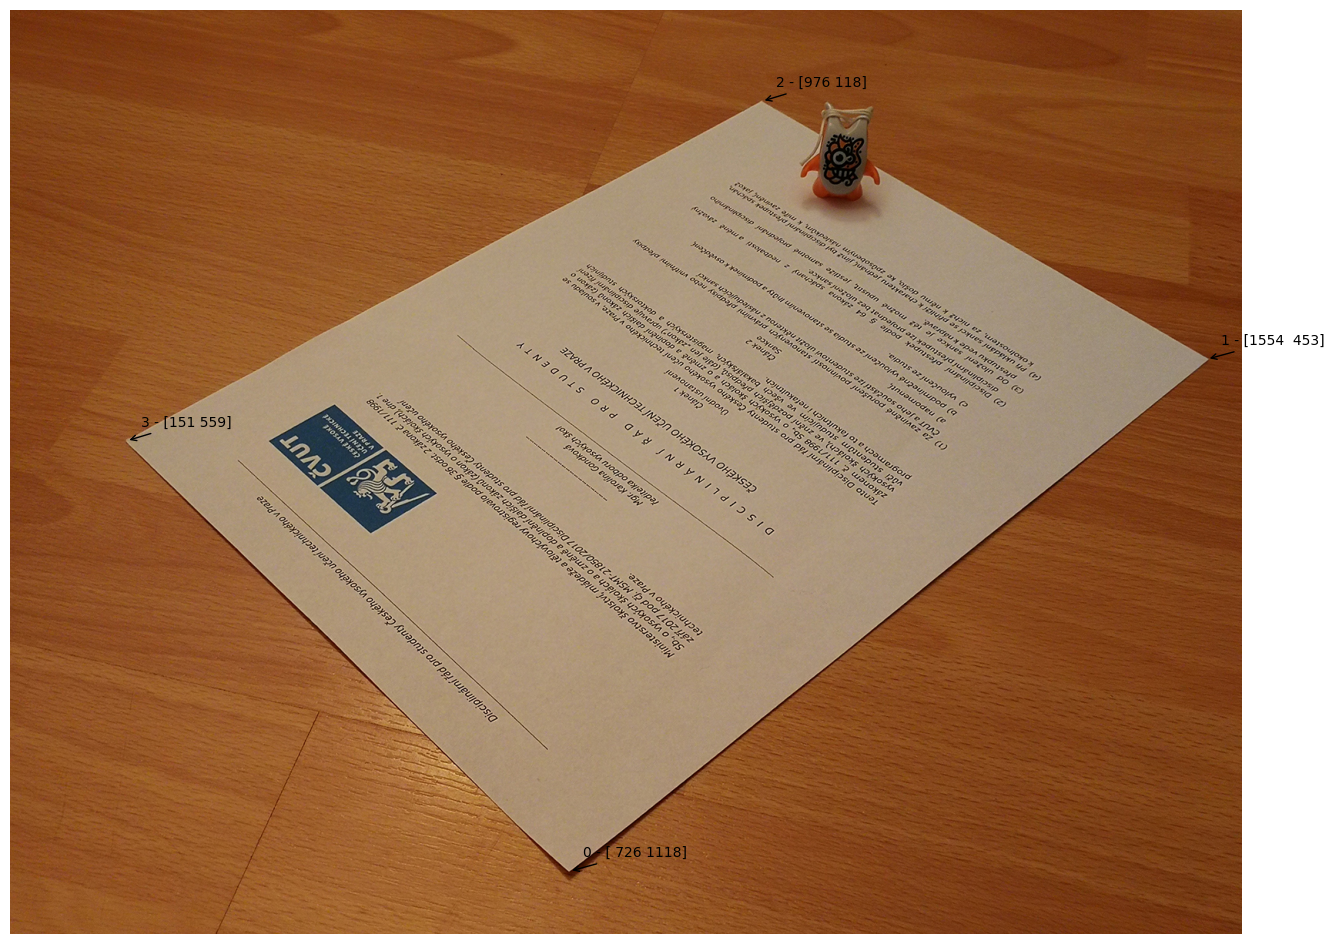

In [15]:
image_pts = np.array([(726, 1118), (1554, 453), (976, 118), (151, 559)])

if (len(image_pts) != len(real_world_pts)):
    raise ValueError('Real world points and image points must be the same size.')

print('format: x, y \n', image_pts)

plot_images(image)
for i, pt in enumerate(image_pts):
    plt.annotate(str(i) + " - " + str(pt), xy=pt, textcoords="offset points", xytext=(10,10), arrowprops=dict(arrowstyle="->"))

**3) Vypočtěte transformační matici H, vypište její tvar.**

In [4]:
H, mask = cv2.findHomography(image_pts, real_world_pts)
print(H)

[[-2.504 -3.117 5302.710]
 [1.378 -1.417 584.148]
 [-0.000 0.001 1.000]]


**4) Popište rozdíl mezi [`cv2.getPerspectiveTransform()`](https://docs.opencv.org/3.4.1/da/d54/group__imgproc__transform.html#ga8c1ae0e3589a9d77fffc962c49b22043) a [`cv2.findHomography`](https://docs.opencv.org/3.4.1/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780).**

getPerspectiveTransform je speciální případ findHomography. Oboje vytvoří 3x3 matici, kterou lze následní použít pro transformaci z jedné roviny na druhou, ale getPerspectiveTransform je připravena přesně pro 4 páry bodů na dvou rovinách, zatímco findHomography je obecnější funkce, kde můžeme použít jiný počet párů bodů a zvolit jinou metodu pro výpočet matice.

**5) Využijte funkci [`cv2.warpPerspective`](https://docs.opencv.org/3.4.1/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87) k vytvoření kolmého pohledu dokumentu, výsledek zobrazte a uložte.**

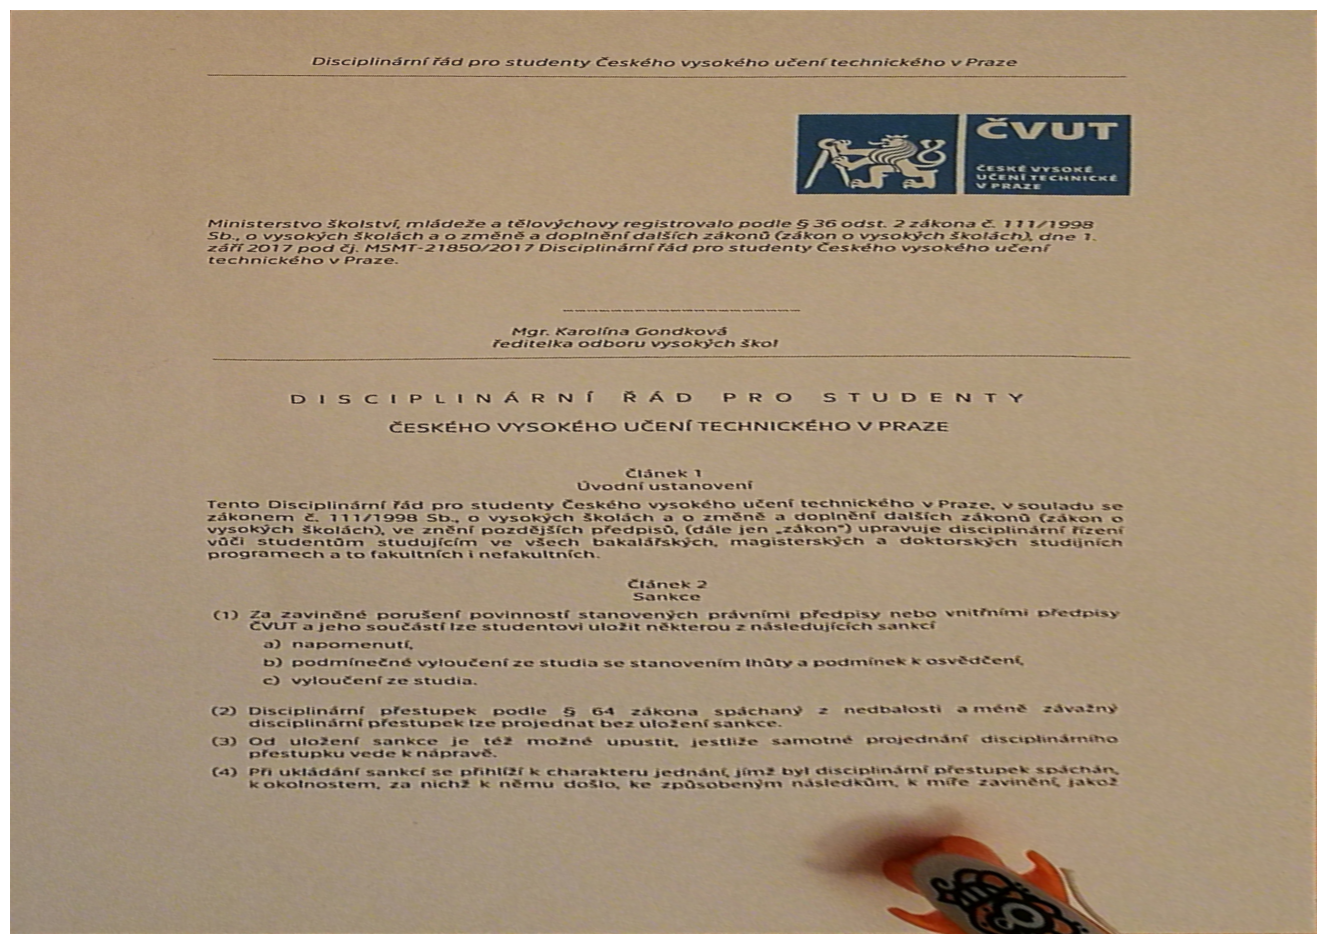

In [5]:
warped_img = cv2.warpPerspective(image, H, (8*297, 8*210)) ###
plot_images(warped_img)

**6) Zprovozněte si účet na Google Cloudu, abyste mohli využívat službu Cloud Vision API.**

Instrukce ke zprovoznění je k nalezení na [Courses](https://courses.fit.cvut.cz/BI-SVZ/tutorials/google-cloud.html).


**7) Detekujte text na "narovnaném" obraze pomocí níže uvedené funkce, text vypiště a uložte do textového souboru.** 

In [6]:
def ocr_google(img_path):
    """Detects text in the file."""
    
    api_key = 'api-key.json'
    assert os.path.exists(api_key), 'There is no API-KEY in your path! You need to contact google to get one.'
    client = vision.ImageAnnotatorClient.from_service_account_json(api_key)
    
    with io.open(img_path, 'rb') as image_file:
        content = image_file.read()

    image = vision.Image(content=content)
    response = client.text_detection(image=image)
    annotations = response.text_annotations

    return annotations

Tesseract má mnohem větší problém s deformovaným textem než OCR od googlu, takže výsledek není úplně zázrak. Přesto to není ani žádná hrůza a spousta textu je přečtena správně.

In [7]:
# since google cloud method is not possible :(
text = pytesseract.image_to_string(warped_img, lang='ces')
print(text)

Disciplinární řád pro studenty Českého vysokého učení technického v Praze

 

(sA Ví kam

at odkazů
ČErNĚ FE CHM:
W PRAZE

 

Pinisterstvo Školství rmiádeže a tělovýchovy registrovalo podle S360dst 2z=8škonaď 223/2908
Sb., o vysokých školách a o zrměně a doplnění dalších zákonů (Zákon o vysokých Skořšc?) cine z
září 2017 pod čj. $4SM4T-21850O/2O01 7 Disciplinární řád pro studenty Českého vysokého uleonf
technického v Praze.

 

Par. Karolína Goncdkově
ředitelka odboru vysokých ško!

DISCIPLIN ÁRNÍ Ř Á D PRO SK UODLESN R hé

ČESKÉHO VYSOKÉHO UČENÍ TECHNICKÉHO V PRAZE

Čišnek 1
Uvodní ustanovení

Tento Disciplinární řád pro studenty Českého vysokého učení technického v Praze, vsouladu se
zákonern č. 111/1998 Sb. o vysokých školách a o změně a doplnění datších zákonů (zákon o
vysokých školách) ve znění pozdějších předpisů, (dále jen „zákon“) upravuje disciplinární řízení
vůči Studentům studujícírm: ve všech bakalářských. mnagisterských a doktorských studijních
prosgrarnech a to fakultních

#### Bonus k první části
Jak je vidět, výsledky po aplikaci OCR nejsou zcela uspokojivé. Je však v nutné brát potaz, že vstupní obraz není kromě geometrické transformace nijak dále předzpracován. Vzpomeňte si na cvičení, kde jsme aplikovali OCR s knihovnou Tesseract. Tam byly poměrně přísné nároky na vstupní obraz, který musel být perfektně předzpracovaný a v binární podobě. Tesseract je citlivý i na drobné natočení nebo deformování textu. Řešení od Google je v tomto ohledu značně robustnější.

**8) Pokuste se vstupní obraz před aplikací OCR kvalitněji předzpracovat pomocí probíraných technik - crop, segmentace, zaostření, rozmazání, jas, kontrast, apod. Fantazii se meze nekladou. Stručně diskutujte poznatky a vlivy jednotlivých operací na výslednou kvalitu. <span style="color:blue">(0.5 bodu)</span>**

**9) Využijte Google Cloud Translate API k přeložení výsledného textu do angličtiny, výsledek zobrazte a uložte do textového souboru. <span style="color:blue">(0.5 bodu)</span>**

### Druhá část - výtvarné umění na FITu
Práce probíhá s fotografií `fit_budova.jpg` od autora Tomáše Kouby a s malbou `fit_logo.jpg` od autora Lukáš Brchla. Cílem je umístit obrázek loga na stěnu budovy FITu viz obrázek. Za tuto část je možné získat maximálně **3 body** a **až 1 prémiový**.

![](fit_logo_merged.jpg)

**1) Načtěte obrázky a vytvořte pole korespondečních souřadnic rohů malby.**

In [20]:
main_img = load_image('fit_budova.jpg')
logo_img = load_image('fit_logo.jpg')

logo_pts = np.array([(0, 0), (0, 719), (141, 719), (141, 0)])

**2) Vyberte souřadnice v obraze, do kterých má být logo transformováno (pozor na pořadí).**

format: x, y 
 [[188  27]
 [ 70 416]
 [171 411]
 [250  66]]


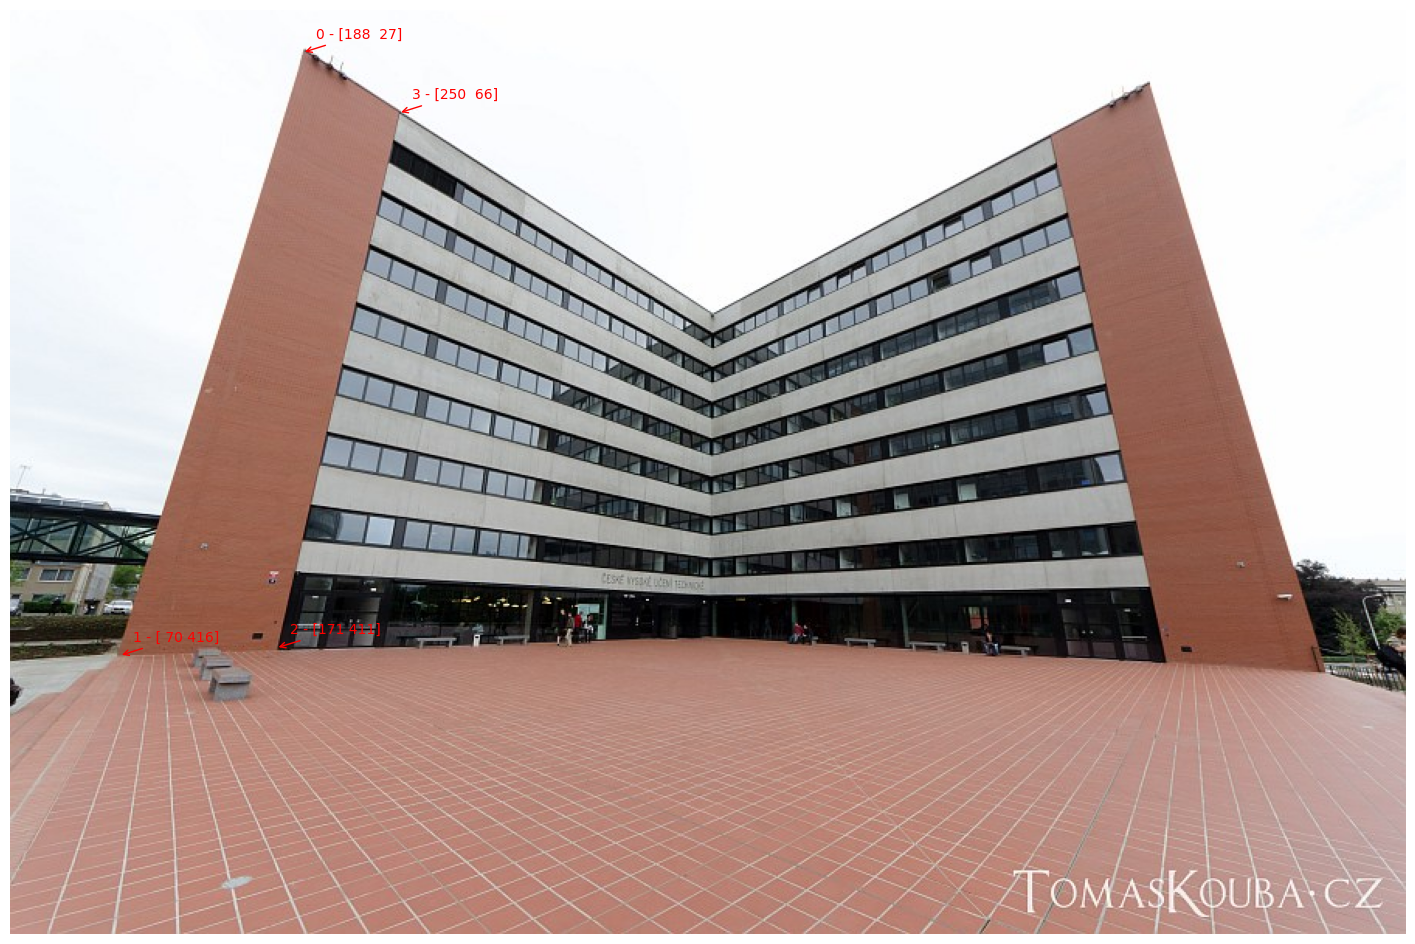

In [21]:
image_pts = np.array([(188, 27), (70, 416), (171,411), (250, 66)])
if (len(image_pts) != len(logo_pts)):
    raise ValueError('Real world points and image points must be the same size.')

print('format: x, y \n', image_pts)

plot_images(main_img)
for i, pt in enumerate(image_pts):
    plt.annotate(str(i) + " - " + str(pt), xy=pt, textcoords="offset points", xytext=(10,10), arrowprops=dict(arrowstyle="->", color='r'), color='r')

**3) Vypočtěte transformační matici H, vypište její tvar.**

In [22]:
H, mask = cv2.findHomography(logo_pts, image_pts)
print(H)

[[0.658 -0.192 188.000]
 [0.334 0.373 27.000]
 [0.001 -0.000 1.000]]


**4) Využijte funkci `cv2.warpPerspective()` k vytvoření stejné perspektivy loga jako fotografie budovy. Zobrazte výsledky.**

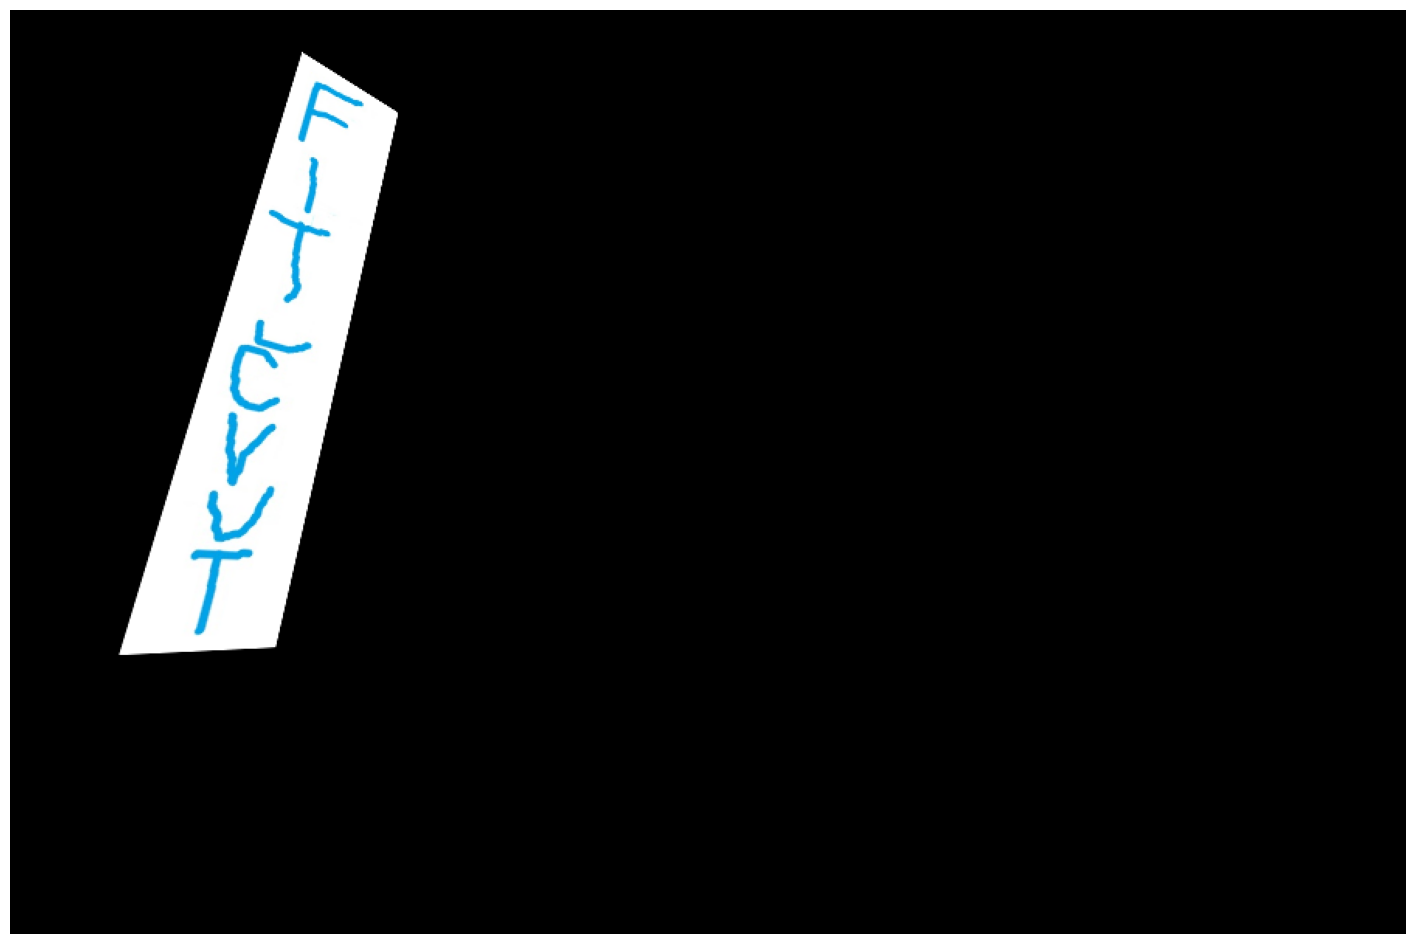

In [23]:
warped_img = cv2.warpPerspective(logo_img, H, (main_img.shape[1], main_img.shape[0])) ###
plot_images(warped_img)

**5) Logo je nutné umístit na budovu bez bílého pozadí, je tedy nutné ho segmentovat.**

Tady se mohou vaše postupy lišit. Kvalita segmentace následně razantně rozhoduje o kvalitě výsledku. Zkuste experimentovat s různými druhy segmentace a zkuste využít i nějaké funkce pro předzpracování, jako např. rozmazání. Může se vám hodit funkce `cv2.bitwise_and`.

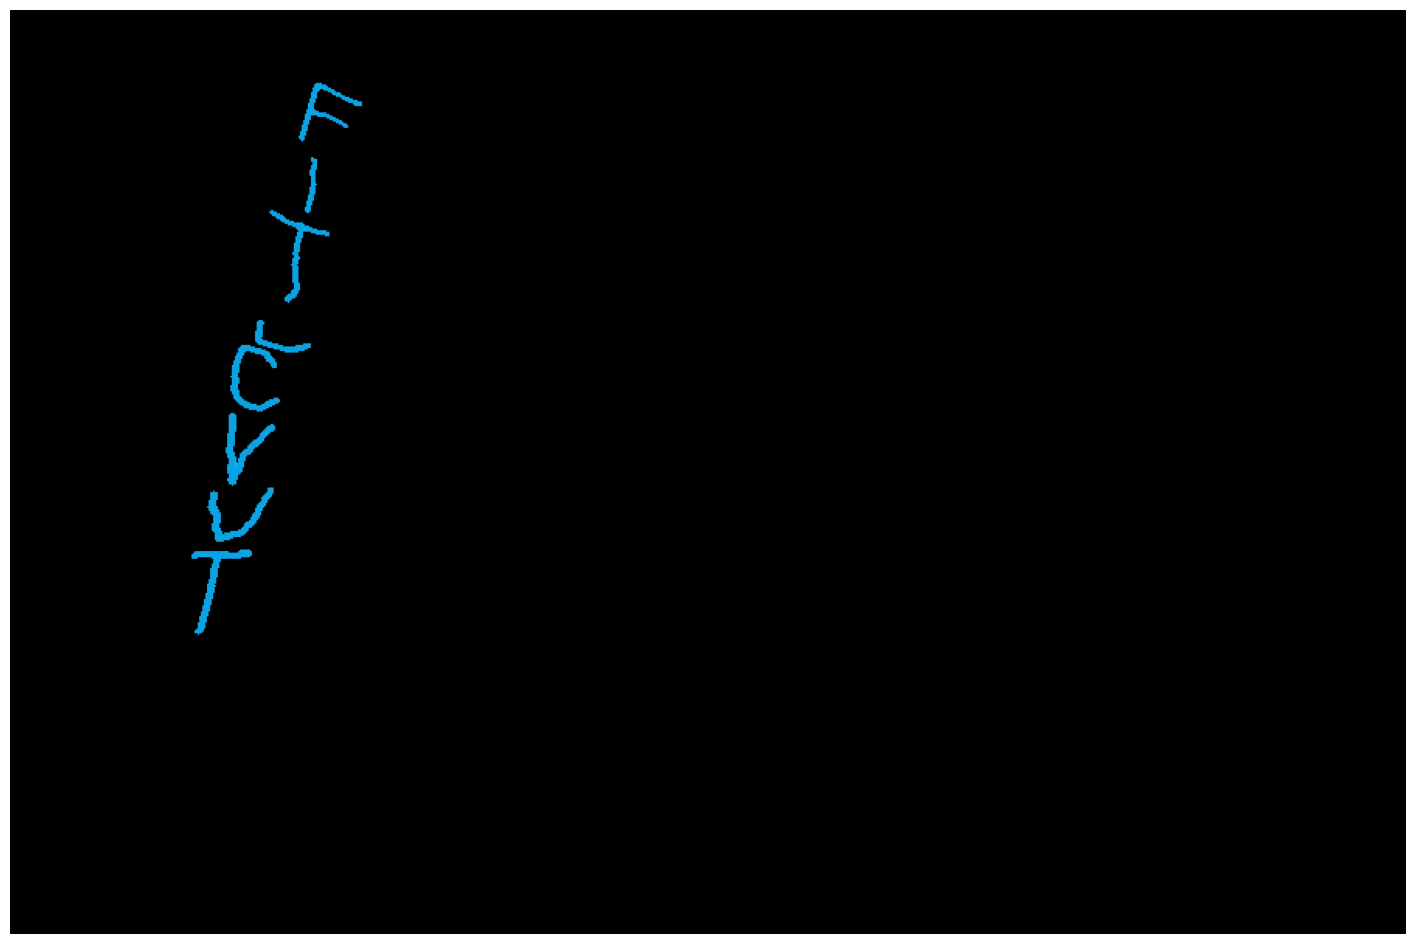

In [24]:
# after some trying, this blur seems to give the best result
warped_img_blurred = cv2.bilateralFilter(warped_img.copy(), 10, 75, 75)
# since I have only one color, it's easier to use gray scale
gray = to_gray(warped_img_blurred)
# the text will have very specific small range of values
text = segmentation_two_thresholds(gray, 121, 135)
_, _, contours = find_contours(text, 50, np.inf)

# create mask, because the text is only gray (2D) and I need color for bitwise_and (3D)
mask = np.zeros_like(warped_img_blurred)
cv2.drawContours(mask, contours, -1, (255, 255, 255), thickness=cv2.FILLED)

result = cv2.bitwise_and(warped_img_blurred, mask)
plot_images(result)

**6) Spojte zdrojovou fotografii budovy se segmentovaným logem. Výsledek zobrazte a uložte.**

Využijte operace numpy či opencv, pozor ať je zachována úroveň jasu. 

Pokud pixely z textu nejsou

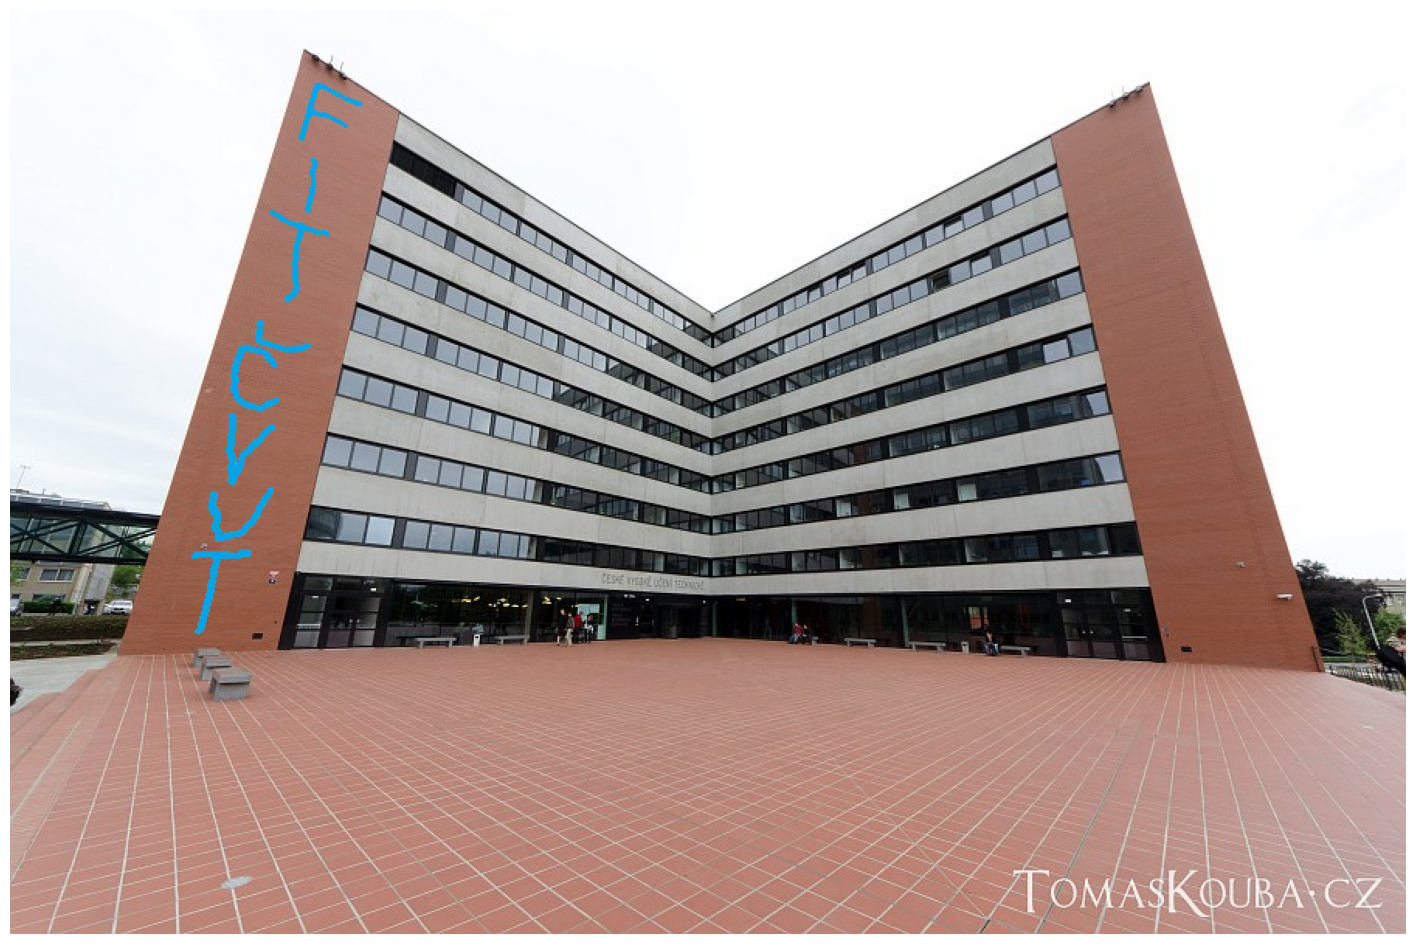

In [32]:
# if there are some non black (or white if the segmentation ) pixels in the text, use those pixels, use main image otherwise
merged_img = np.where((result > 0) & (result < 240) , result, main_img)
plot_images(merged_img)

#### Bonus k druhé části
**7) Vymyslete a naprogramujte další využití perspektivní transformace pro nadcházející studenty BI-SVZ. Pro získání nápadu se lze odpíchnout od témat spojování snímků (panorama), rozšířené reality a 3D rekonstrukce. Pokud vůbec netušíte, hledejte v Google images klíčová slova "homography" nebo "perspective transform". Znovu podotýkám, že fantazii se meze nekladou a nebojte se případné dotazy/nápady konzultovat přímo s námi! <span style="color:blue">(1 bod)</span>**


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ed8d7744-c5a7-4ba0-b10a-ec68df100cd1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>